In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

In [53]:
df = pd.read_excel('consoecppl.xlsx', parse_dates=['Date'])

df.head()

,Main Account,Remarks,LOB2,Value,Date,Account_Description,Year
0,COST OF SERVICES/SALES,Actual,Direct Cost - Internet Connectivity,26285.12,2022-07-01,Direct Cost - Internet Service Fee,2022
1,COST OF SERVICES/SALES,Actual,Direct Cost - Internet Connectivity,-28200.00,2022-07-01,Direct Cost - Internet Service Fee,2022
2,COST OF SERVICES/SALES,Actual,Direct Cost - Internet Connectivity,6600.00,2022-07-01,Direct Cost - Internet Service Fee,2022
3,COST OF SERVICES/SALES,Actual,Direct Cost - Internet Connectivity,239428.57,2022-07-01,Direct Cost - Internet Service Fee,2022
4,COST OF SERVICES/SALES,Actual,Direct Cost - Internet Connectivity,13000.00,2022-07-01,Direct Cost - Internet Service Fee,2022


In [54]:
df = df[['Date', 'Main Account', 'Value']].copy()

df = pd.pivot_table(df, values='Value', index=['Date'], columns=['Main Account'], aggfunc='sum')

df.fillna(0, inplace=True)

df.to_excel('CLEANED_ECPI_FINANCIALS.xlsx', sheet_name='Sheet1')

df = pd.read_excel('CLEANED_ECPI_FINANCIALS.xlsx')

df.head()

,Date,COST OF SERVICES/SALES,INTEREST EXPENSE,OPEX,OTHER INCOME/EXPENSE,REVENUES
0,2019-01-01,184757.04,0.0,0.0,0.0,935334.54
1,2019-01-14,0.00,0.0,523.2,8997.9,0.00
2,2019-01-17,0.00,0.0,26708.0,0.0,0.00
3,2019-01-18,0.00,0.0,1400.0,0.0,0.00
4,2019-01-23,0.00,0.0,6236.0,0.0,0.00


In [55]:
def create_additional_features(df, contribution_margin, ebit, earnings_before_interest, nibt):
    df[contribution_margin] = df['REVENUES'] - df['COST OF SERVICES/SALES']
    df[ebit] = df[contribution_margin] - df['OPEX']
    df[earnings_before_interest] = df['OTHER INCOME/EXPENSE'] + df[ebit]
    df[nibt] = df[earnings_before_interest] - df['INTEREST EXPENSE']
    return df

def date_and_groupby_formatter(df, columns):
    df = df.copy()
    df['Date'] = df['Date'].dt.to_period('m')
    df['Date'] = df['Date'].dt.to_timestamp()
    df = df.groupby(['Date'], as_index=False)[columns].sum().copy()
    return df

to_group_columns = ['CONTRIBUTION MARGIN', 'COST OF SERVICES/SALES', 'INTEREST EXPENSE', 'OPEX', 'OTHER INCOME/EXPENSE', 'REVENUES', 'EBIT', 'EARNINGS BEFORE INTEREST', 'NIBT']

df = create_additional_features(df, 'CONTRIBUTION MARGIN', 'EBIT', 'EARNINGS BEFORE INTEREST', 'NIBT')
df = date_and_groupby_formatter(df, to_group_columns)

df.set_index('Date', inplace=True)

df.head()

,CONTRIBUTION MARGIN,COST OF SERVICES/SALES,INTEREST EXPENSE,OPEX,OTHER INCOME/EXPENSE,REVENUES,EBIT,EARNINGS BEFORE INTEREST,NIBT
Date,,,,,,,,,
2019-01-01,750577.50,184757.04,0.0,210038.46,8754.00,935334.54,540539.04,549293.04,549293.04
2019-02-01,103943.55,1986745.28,0.0,258316.11,-11820.18,2090688.83,-154372.56,-166192.74,-166192.74
2019-03-01,764336.22,225138.32,0.0,483594.04,-2648.42,989474.54,280742.18,278093.76,278093.76
2019-04-01,780186.18,224703.12,0.0,299800.44,8293.08,1004889.30,480385.74,488678.82,488678.82
2019-05-01,1726331.37,2702865.86,0.0,1360432.59,-1216.32,4429197.23,365898.78,364682.46,364682.46


## Revenues

In [56]:
revenues_df = df[['REVENUES']].reset_index().copy()

revenues_df

,Date,REVENUES
0,2019-01-01,935334.54
1,2019-02-01,2090688.83
2,2019-03-01,989474.54
3,2019-04-01,1004889.30
4,2019-05-01,4429197.23
...,...,...
61,2024-02-01,12658996.31
62,2024-03-01,11700992.29
63,2024-04-01,14752661.41
64,2024-05-01,9004438.26


In [57]:
revenues_df.rename(columns={'Date': 'ds', 'REVENUES': 'y'},inplace= True)

revenues_df.head()

,ds,y
0,2019-01-01,935334.54
1,2019-02-01,2090688.83
2,2019-03-01,989474.54
3,2019-04-01,1004889.30
4,2019-05-01,4429197.23


In [58]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'holidays_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

grid = ParameterGrid(param_grid=param_grid)

In [59]:
best_params = None
best_error = float('inf')

for params in grid:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    model.fit(revenues_df)

    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)

    y_true = revenues_df['y']
    y_pred = forecast['yhat'][:len(revenues_df)]
    error = mean_absolute_error(y_true=y_true, y_pred=y_pred)

    if error < best_error:
        best_error = error
        best_params = params

print(f'Best Params: {best_params}')
print(f'Best MAE: {best_error}')

11:39:51 - cmdstanpy - INFO - Chain [1] start processing
11:39:51 - cmdstanpy - INFO - Chain [1] done processing
11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:39:54 - cmdstanpy - INFO - Chain [1] done processing
11:39:54 - cmdstanpy - INFO - Chain [1] start processing
11:39:55 - cmdstanpy - INFO - Chain [1] done processing
11:39:55 - cmdstanpy - INFO - Chain [1] start processing
11:39:56 - cmdstanpy - INFO - Chain [1] done processing
11:39:56 - cmdstanpy - INFO - Chain [1] start processing
11:39:57 - cmdstanpy - INFO - Chain [1] done processing
11:39:58 - cmdstanpy - INFO - Chain [1] start processing
11:39:58 - cmdstanpy - INFO - Chain [1] done processing
11:39:59 - cmdstanpy - INFO - Chain [1] start processing
11:40:00 - cmdstanpy - INFO - Chain [1] done processing
11:40:00 - cmdstanpy - INFO - Chain [1] start processing
11:40:01 - cmdstanpy - INFO - Chain [1] done processing
11:40:02 - cmdstanpy - INFO - Chain [1] start processing
11:40:03 - cmdstanpy - INFO - Chain [1]

Best Params: {'changepoint_prior_scale': 20.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.0}
Best MAE: 870729.006199682


In [60]:
best_params

{'changepoint_prior_scale': 20.0,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 20.0}

In [61]:
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

final_model.fit(revenues_df)

future = final_model.make_future_dataframe(periods=6, freq='M')
forecast = final_model.predict(future)

12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
revenues_df_w_forecast = revenues_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

y_true = revenues_df_w_forecast['y']
y_pred = revenues_df_w_forecast['yhat']

mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 870729.006199682


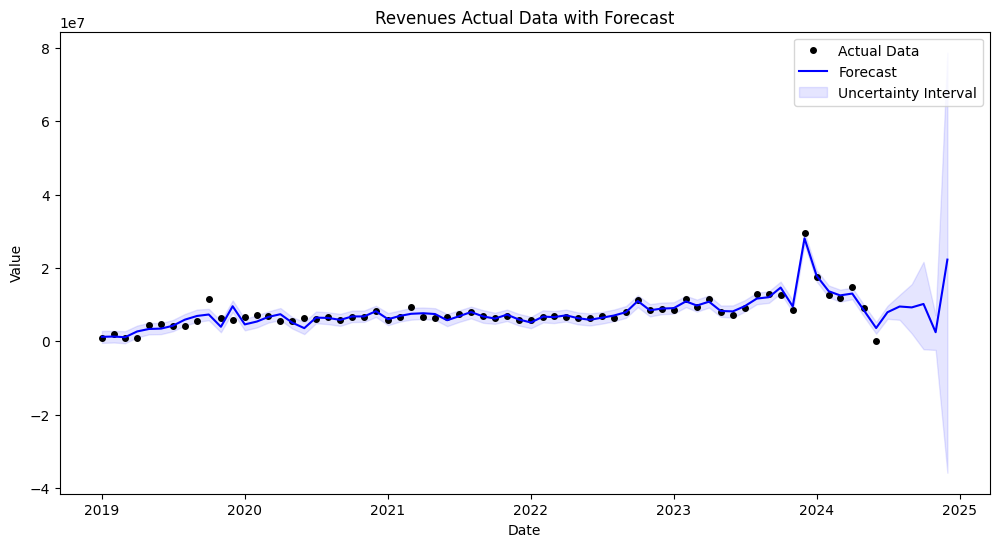

In [63]:
# Plot the actual data and forecast
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(revenues_df['ds'], revenues_df['y'], 'ko', markersize=4, label='Actual Data')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.1, label='Uncertainty Interval')

# Customize the plot
plt.title('Revenues Actual Data with Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## Contribution Margin

In [64]:
cm_df = df[['CONTRIBUTION MARGIN']].reset_index().copy()

cm_df.head()

,Date,CONTRIBUTION MARGIN
0,2019-01-01,750577.50
1,2019-02-01,103943.55
2,2019-03-01,764336.22
3,2019-04-01,780186.18
4,2019-05-01,1726331.37


In [65]:
cm_df.rename(columns={'Date': 'ds', 'CONTRIBUTION MARGIN': 'y'},inplace= True)

cm_df.head()

,ds,y
0,2019-01-01,750577.50
1,2019-02-01,103943.55
2,2019-03-01,764336.22
3,2019-04-01,780186.18
4,2019-05-01,1726331.37


In [66]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'holidays_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

grid = ParameterGrid(param_grid=param_grid)

best_params = None
best_error = float('inf')

for params in grid:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    model.fit(cm_df)

    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)

    y_true = cm_df['y']
    y_pred = forecast['yhat'][:len(cm_df)]
    error = mean_absolute_error(y_true=y_true, y_pred=y_pred)

    if error < best_error:
        best_error = error
        best_params = params

print(f'Best Params: {best_params}')
print(f'Best MAE: {best_error}')

12:21:09 - cmdstanpy - INFO - Chain [1] start processing
12:21:09 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:11 - cmdstanpy - INFO - Chain [1] start processing
12:21:11 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:12 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing
12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1] done processing
12:21:14 - cmdstanpy - INFO - Chain [1] start processing
12:21:14 - cmdstanpy - INFO - Chain [1]

Best Params: {'changepoint_prior_scale': 12.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.0}
Best MAE: 520265.0138998176


In [67]:
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

final_model.fit(cm_df)

future = final_model.make_future_dataframe(periods=6, freq='M')
forecast = final_model.predict(future)

13:04:56 - cmdstanpy - INFO - Chain [1] start processing
13:04:56 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
cm_new_df = cm_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

y_true = cm_new_df['y']
y_pred = cm_new_df['yhat']

mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 520265.0138998176


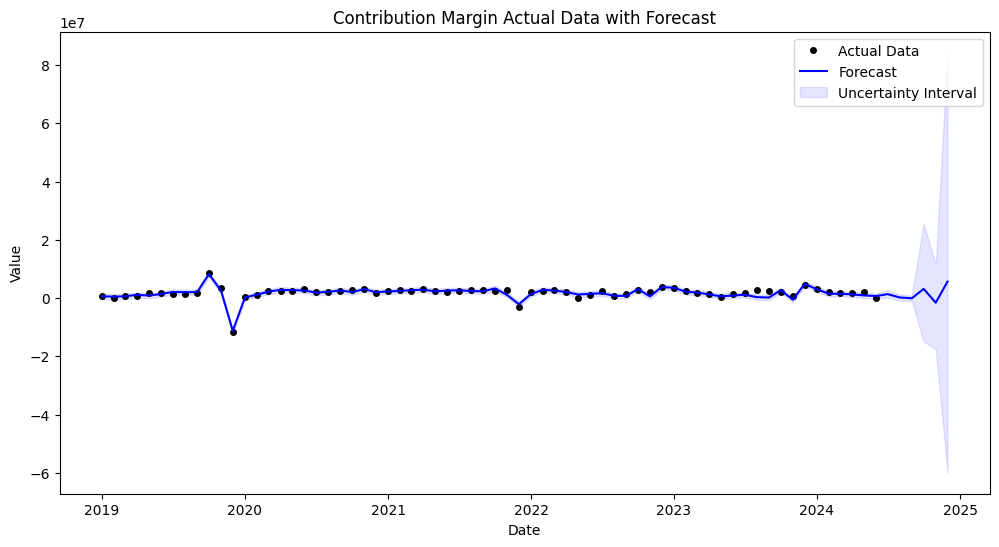

In [69]:
# Plot the actual data and forecast
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(cm_df['ds'], cm_df['y'], 'ko', markersize=4, label='Actual Data')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.1, label='Uncertainty Interval')

# Customize the plot
plt.title('Contribution Margin Actual Data with Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## OPEX

In [70]:
OPEX_df = df[['OPEX']].reset_index().copy()

OPEX_df.head()

,Date,OPEX
0,2019-01-01,210038.46
1,2019-02-01,258316.11
2,2019-03-01,483594.04
3,2019-04-01,299800.44
4,2019-05-01,1360432.59


In [71]:
OPEX_df.rename(columns={'Date': 'ds', 'OPEX': 'y'},inplace= True)

OPEX_df.head()

,ds,y
0,2019-01-01,210038.46
1,2019-02-01,258316.11
2,2019-03-01,483594.04
3,2019-04-01,299800.44
4,2019-05-01,1360432.59


In [72]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'holidays_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

grid = ParameterGrid(param_grid=param_grid)

best_params = None
best_error = float('inf')

for params in grid:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    model.fit(OPEX_df)

    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)

    y_true = OPEX_df['y']
    y_pred = forecast['yhat'][:len(OPEX_df)]
    error = mean_absolute_error(y_true=y_true, y_pred=y_pred)

    if error < best_error:
        best_error = error
        best_params = params

print(f'Best Params: {best_params}')
print(f'Best MAE: {best_error}')

13:04:57 - cmdstanpy - INFO - Chain [1] start processing
13:04:58 - cmdstanpy - INFO - Chain [1] done processing
13:04:58 - cmdstanpy - INFO - Chain [1] start processing
13:04:58 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] start processing
13:04:59 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] start processing
13:05:00 - cmdstanpy - INFO - Chain [1] done processing
13:05:00 - cmdstanpy - INFO - Chain [1] start processing
13:05:00 - cmdstanpy - INFO - Chain [1] done processing
13:05:01 - cmdstanpy - INFO - Chain [1] start processing
13:05:01 - cmdstanpy - INFO - Chain [1] done processing
13:05:01 - cmdstanpy - INFO - Chain [1] start processing
13:05:02 - cmdstanpy - INFO - Chain [1] done processing
13:05:02 - cmdstanpy - INFO - Chain [1] start processing
13:05:02 - cmdstanpy - INFO - Chain [1] done processing
13:05:03 - cmdstanpy - INFO - Chain [1] start processing
13:05:03 - cmdstanpy - INFO - Chain [1]

Best Params: {'changepoint_prior_scale': 20.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.0}
Best MAE: 310031.9209465447


In [73]:
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

final_model.fit(OPEX_df)

future = final_model.make_future_dataframe(periods=6, freq='M')
forecast = final_model.predict(future)

13:56:37 - cmdstanpy - INFO - Chain [1] start processing
13:56:38 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
OPEX_new_df = OPEX_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

y_true = OPEX_new_df['y']
y_pred = OPEX_new_df['yhat']

mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 310031.9209465447


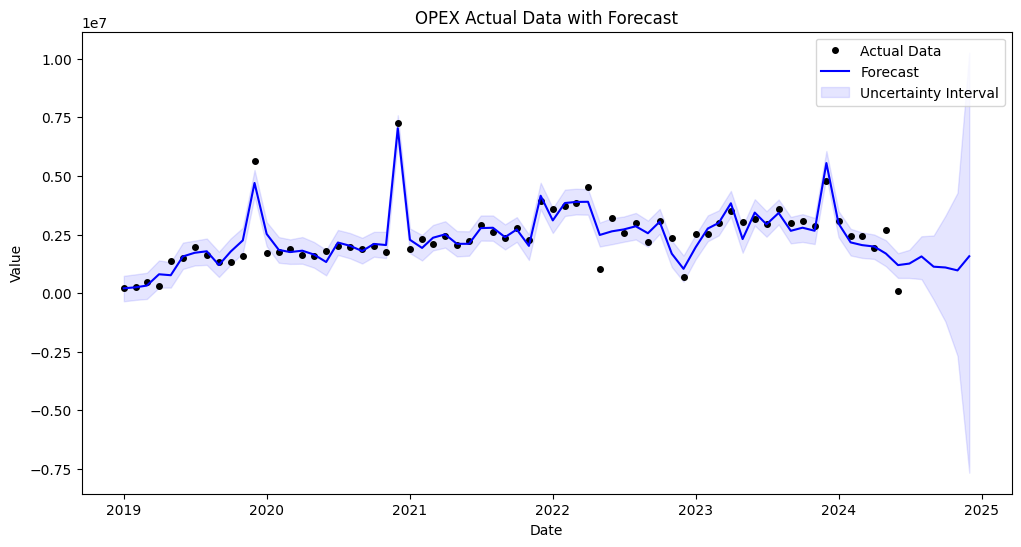

In [78]:
# Plot the actual data and forecast
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(OPEX_df['ds'], OPEX_df['y'], 'ko', markersize=4, label='Actual Data')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.1, label='Uncertainty Interval')

# Customize the plot
plt.title('OPEX Actual Data with Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## NIBT

In [108]:
NIBT_df = df[['NIBT']].reset_index().copy()

NIBT_df.head()

,Date,NIBT
0,2019-01-01,549293.04
1,2019-02-01,-166192.74
2,2019-03-01,278093.76
3,2019-04-01,488678.82
4,2019-05-01,364682.46


In [109]:
NIBT_df.rename(columns={'Date': 'ds', 'NIBT': 'y'},inplace= True)

NIBT_df.head()

,ds,y
0,2019-01-01,549293.04
1,2019-02-01,-166192.74
2,2019-03-01,278093.76
3,2019-04-01,488678.82
4,2019-05-01,364682.46


In [99]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'holidays_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

grid = ParameterGrid(param_grid=param_grid)

best_params = None
best_error = float('inf')

for params in grid:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    model.fit(NIBT_df)

    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)

    y_true = NIBT_df['y']
    y_pred = forecast['yhat'][:len(NIBT_df)]
    error = mean_absolute_error(y_true=y_true, y_pred=y_pred)

    if error < best_error:
        best_error = error
        best_params = params

print(f'Best Params: {best_params}')
print(f'Best MAE: {best_error}')

15:38:07 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:09 - cmdstanpy - INFO - Chain [1] done processing
15:38:09 - cmdstanpy - INFO - Chain [1] start processing
15:38:10 - cmdstanpy - INFO - Chain [1] done processing
15:38:10 - cmdstanpy - INFO - Chain [1] start processing
15:38:11 - cmdstanpy - INFO - Chain [1] done processing
15:38:11 - cmdstanpy - INFO - Chain [1] start processing
15:38:12 - cmdstanpy - INFO - Chain [1] done processing
15:38:12 - cmdstanpy - INFO - Chain [1] start processing
15:38:12 - cmdstanpy - INFO - Chain [1] done processing
15:38:13 - cmdstanpy - INFO - Chain [1] start processing
15:38:14 - cmdstanpy - INFO - Chain [1] done processing
15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:15 - cmdstanpy - INFO - Chain [1] done processing
15:38:15 - cmdstanpy - INFO - Chain [1] start processing
15:38:15 - cmdstanpy - INFO - Chain [1]

Best Params: {'changepoint_prior_scale': 20.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.5}
Best MAE: 285911.03023679


In [100]:
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

final_model.fit(NIBT_df)

future = final_model.make_future_dataframe(periods=6, freq='M')
forecast = final_model.predict(future)

16:43:23 - cmdstanpy - INFO - Chain [1] start processing
16:43:24 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
NIBT_new_df = NIBT_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

y_true = NIBT_new_df['y']
y_pred = NIBT_new_df['yhat']

mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 285911.03023679


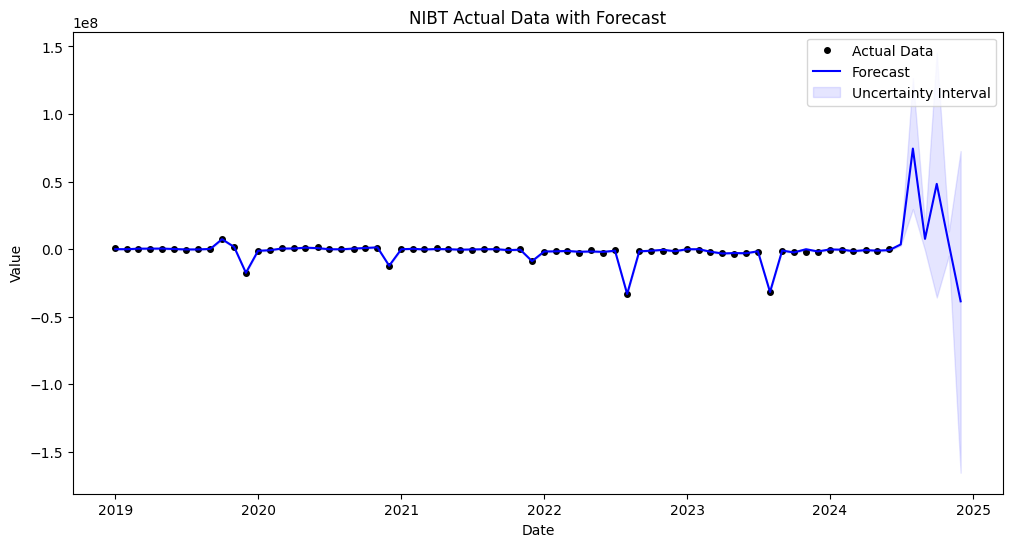

In [111]:
# Plot the actual data and forecast
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(NIBT_new_df['ds'], NIBT_new_df['y'], 'ko', markersize=4, label='Actual Data')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.1, label='Uncertainty Interval')

# Customize the plot
plt.title('NIBT Actual Data with Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## Direct Cost

In [112]:
DC_df = df[['COST OF SERVICES/SALES']].reset_index().copy()

DC_df.head()

,Date,COST OF SERVICES/SALES
0,2019-01-01,184757.04
1,2019-02-01,1986745.28
2,2019-03-01,225138.32
3,2019-04-01,224703.12
4,2019-05-01,2702865.86


In [113]:
DC_df.rename(columns={'Date': 'ds', 'COST OF SERVICES/SALES': 'y'},inplace= True)

DC_df.head()

,ds,y
0,2019-01-01,184757.04
1,2019-02-01,1986745.28
2,2019-03-01,225138.32
3,2019-04-01,224703.12
4,2019-05-01,2702865.86


In [114]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'holidays_prior_scale': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

grid = ParameterGrid(param_grid=param_grid)

best_params = None
best_error = float('inf')

for params in grid:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    model.fit(DC_df)

    future = model.make_future_dataframe(periods=6, freq='M')
    forecast = model.predict(future)

    y_true = NIBT_df['y']
    y_pred = forecast['yhat'][:len(DC_df)]
    error = mean_absolute_error(y_true=y_true, y_pred=y_pred)

    if error < best_error:
        best_error = error
        best_params = params

print(f'Best Params: {best_params}')
print(f'Best MAE: {best_error}')

16:53:51 - cmdstanpy - INFO - Chain [1] start processing
16:53:51 - cmdstanpy - INFO - Chain [1] done processing
16:53:51 - cmdstanpy - INFO - Chain [1] start processing
16:53:52 - cmdstanpy - INFO - Chain [1] done processing
16:53:52 - cmdstanpy - INFO - Chain [1] start processing
16:53:53 - cmdstanpy - INFO - Chain [1] done processing
16:53:53 - cmdstanpy - INFO - Chain [1] start processing
16:53:53 - cmdstanpy - INFO - Chain [1] done processing
16:53:54 - cmdstanpy - INFO - Chain [1] start processing
16:53:54 - cmdstanpy - INFO - Chain [1] done processing
16:53:55 - cmdstanpy - INFO - Chain [1] start processing
16:53:55 - cmdstanpy - INFO - Chain [1] done processing
16:53:55 - cmdstanpy - INFO - Chain [1] start processing
16:53:56 - cmdstanpy - INFO - Chain [1] done processing
16:53:56 - cmdstanpy - INFO - Chain [1] start processing
16:53:56 - cmdstanpy - INFO - Chain [1] done processing
16:53:57 - cmdstanpy - INFO - Chain [1] start processing
16:53:57 - cmdstanpy - INFO - Chain [1]

Best Params: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
Best MAE: 7749774.622347156


In [115]:
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

final_model.fit(DC_df)

future = final_model.make_future_dataframe(periods=6, freq='M')
forecast = final_model.predict(future)

17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:55 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
DC_new_df = DC_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

y_true = DC_new_df['y']
y_pred = DC_new_df['yhat']

mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 1357127.0212637605


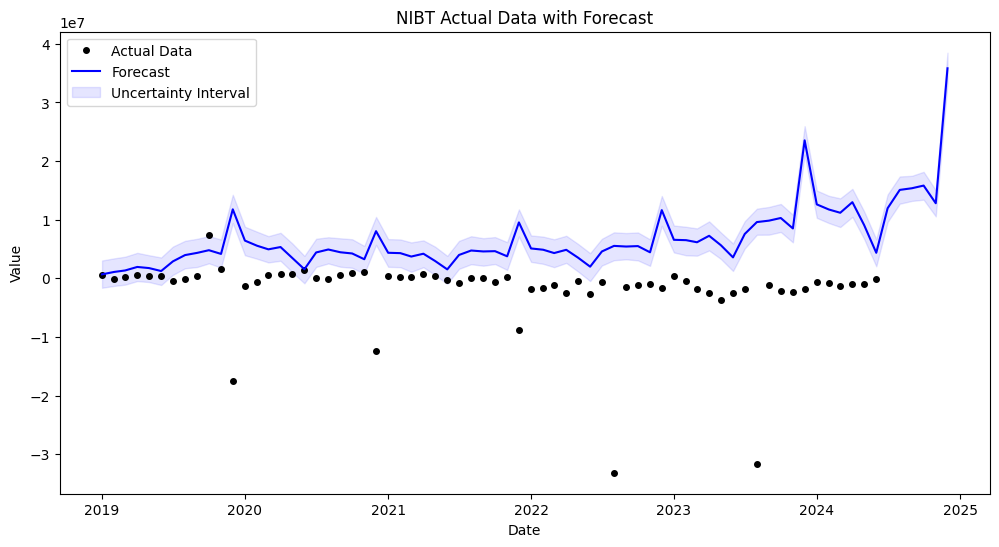

In [117]:
# Plot the actual data and forecast
plt.figure(figsize=(12, 6))

# Plot the actual data
plt.plot(NIBT_new_df['ds'], NIBT_new_df['y'], 'ko', markersize=4, label='Actual Data')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.1, label='Uncertainty Interval')

# Customize the plot
plt.title('NIBT Actual Data with Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
